In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
from modes.vortex import Vortex
from modes.zernike import Zernike
from modes.pixel import Pixel
from helper.propagator import *
from sklearn import linear_model

truncate_circle = False

Set the physical params.

In [2]:
camera_pixel_size = 3.45e-6   #micrometers

grid_pix_per_camera_pix = 25

grid_pixel_size = camera_pixel_size / grid_pix_per_camera_pix


n_wl = 1
wl = torch.linspace(750e-9,850e-9,n_wl)

if grid_pixel_size > wl[0]/4:
    raise ValueError('grid_pixel_size must be smaller than wl/4')

nx = 4000

x = torch.arange(0,nx*grid_pixel_size,grid_pixel_size, )
x = x - x.mean()

y = x.clone()

dx = x[1] - x[0]

xx, yy = torch.meshgrid(x,y)
r = torch.sqrt(xx**2 + yy**2)

c:\Users\Sunny\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Make a custom wavefront...

Text(0.5, 1.0, 'Wavefront')

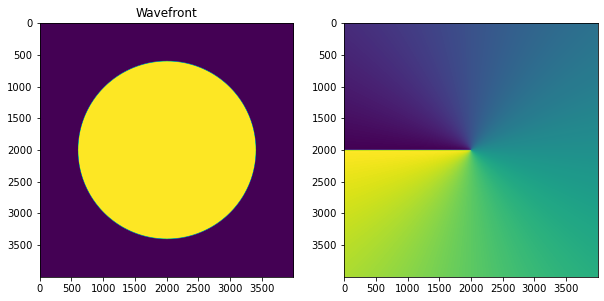

In [4]:
wavefront = torch.zeros((n_wl,nx,nx))
decenter = [0,0]#[2*dx,2*dx]

# shift_zer, _, _ = Zernike(n_zernike,x,y,x0=decenter[0],y0=decenter[1],truncate_circle=truncate_circle)


wavefront += Vortex(2,x,y,x0=decenter[0],y0=decenter[1], truncate_circle=truncate_circle)[0][0]

tophat = (r<x.max()*.7).unsqueeze(0)

E0 = (tophat * torch.exp(1j*2*np.pi/wl[0]*wavefront)).unsqueeze(0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(tophat[0]); ax[0].set_title('Aperture')
ax[1].imshow(wavefront[0]); ax[0].set_title('Wavefront')

In [7]:
E = Sommerfeld(E0, xx, yy, z=dx, wl=wl, pad=0.5)

Text(0.5, 1.0, 'Phase')

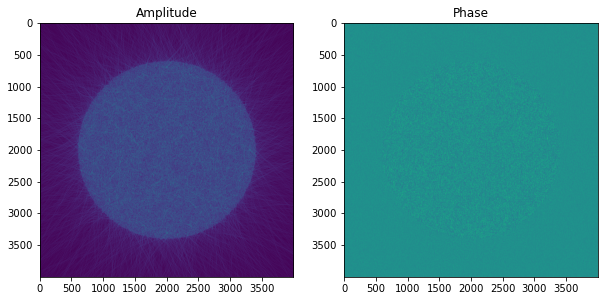

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(torch.abs(E)[0,0]); ax[0].set_title('Amplitude')
ax[1].imshow(torch.angle(E)[0,0]); ax[1].set_title('Phase')

#### Lets calc gradients


In [76]:
positions = np.arange(microlens,dtype=int)
xx,yy = np.meshgrid(positions,positions)


In [77]:
dx, dy = np.gradient(wavefront)


sampled_gradient = np.zeros((2,microlens,microlens))

mode_gradients = np.zeros((2,microlens,microlens,len(modes)))

for i in range(microlens):
    for j in range(microlens):
        sampled_gradient[0,i,j] = dx[int(xx[i,j]),int(yy[i,j])]
        sampled_gradient[1,i,j] = dy[int(xx[i,j]),int(yy[i,j])]
        mode_gradients[0,i,j] = dmodesdx[:,int(xx[i,j]),int(yy[i,j])]
        mode_gradients[1,i,j] = dmodesdy[:,int(xx[i,j]),int(yy[i,j])]



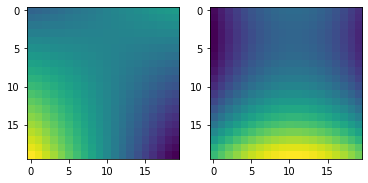

In [78]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(sampled_gradient[0])
ax[1].imshow(sampled_gradient[1])

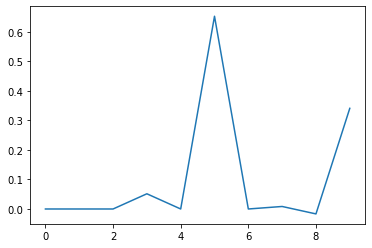

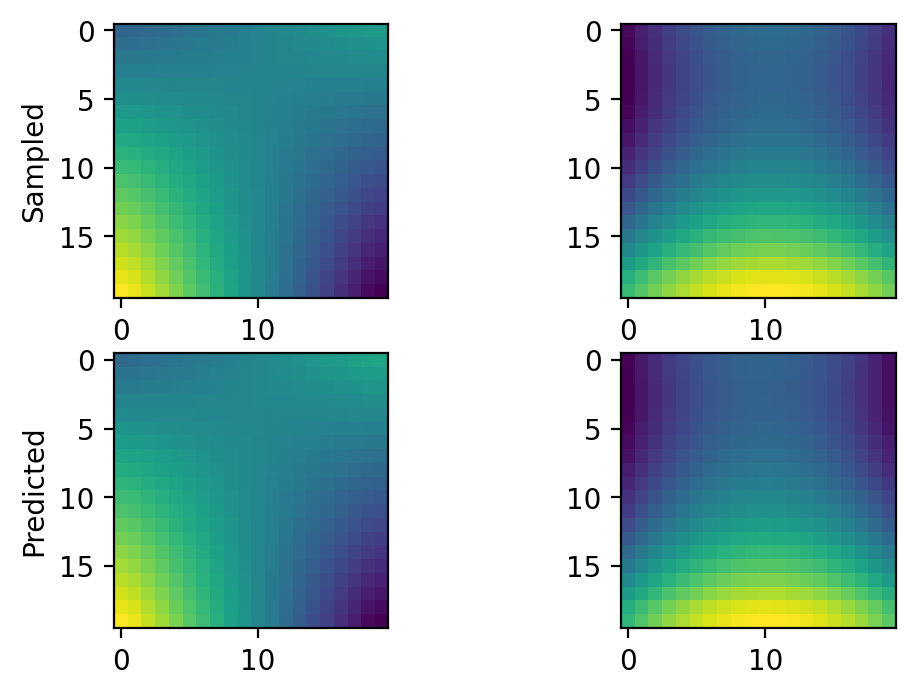

In [79]:
t = sampled_gradient.reshape(-1,1)
u = mode_gradients.reshape(-1,mode_gradients.shape[-1])

clf = linear_model.Lasso(alpha=0.001)
clf.fit(u,t)
result_vector = clf.coef_

wavefront_grad_prediction = (mode_gradients @ result_vector)
plt.figure()
plt.plot(result_vector)


fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(wavefront_grad_prediction[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction[1])


In [21]:
u = torch.tensor(u).permute(1,0).float()

t = torch.tensor(t).permute(1,0).float()

In [22]:
coefficients = torch.nn.Parameter(torch.rand(1,u.shape[0]))
offset = torch.nn.Parameter(torch.zeros(2))

reg_coeff = 5e-3


history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['loss'] = []


In [23]:
lr = 5e-4


epochs = 8000

optimizer = torch.optim.Adam([coefficients], lr=lr)
loss_fn = torch.nn.MSELoss()



for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    # seq_model.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    # coeff_preds = torch.nn.functional.relu(seq_model(x)) #take the gradients for every mode

    pred = (coefficients @ u)

    mse = loss_fn(pred, t)

    reg = torch.norm(coefficients,1) / coefficients.size()[0]

    loss = mse + reg * reg_coeff

    loss.backward()
    optimizer.step()

    



    print(f'Epoch {epoch}/{epochs}:, train mse: {mse:5.5g}, train reg: {reg*reg_coeff:5.5g}',end='\r')


    history2['loss'].append(loss.item())

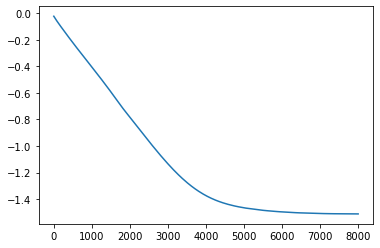

In [25]:
plt.plot(np.log10(history2['loss']))

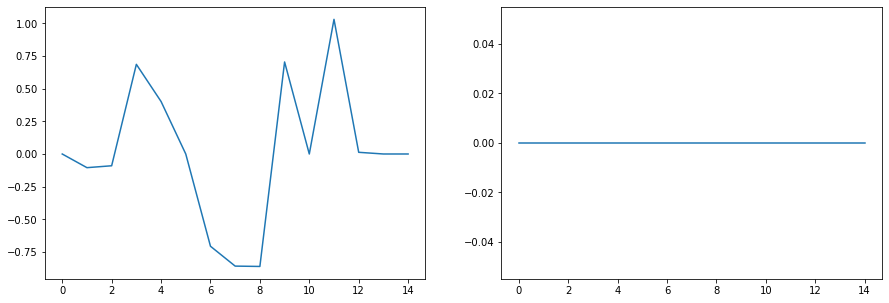

In [26]:

fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(coefficients[0].detach())
ax[1].plot(mode_coeffs[:,0,0])

In [27]:
pred_gradients = pred.reshape(2,20,20).detach().numpy()

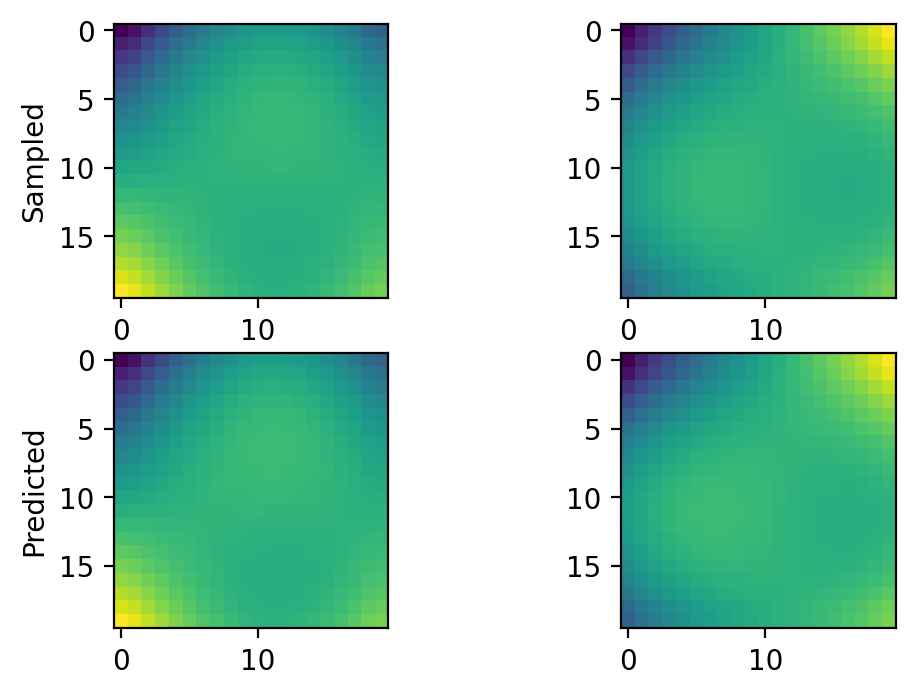

In [28]:
fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(pred_gradients[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(pred_gradients[1])
